# 1D PDE solver with the FiPy package


Requirements:
- future
- fipy
- numpy
- matplotlib
- scipy
- copy

General form of the PDE which we want to solve:

\begin{equation}
\frac{\partial n(r,t)}{\partial t}=D\frac{\partial^2 n(r,t)}{\partial r^2}-K\frac{\partial n(r,t)}{\partial r}+S(r,t) 
\end{equation}

### Package imports and custom functions

The implemented Dirac delta function between
$$ x<\varepsilon\quad\text{and}\quad x>-\varepsilon \text{,}$$
gives:
$$ n_{\delta}(x,\varepsilon)=\frac{(1+\cos(\frac{\pi x}{\varepsilon}))\cdot\varepsilon}{2} $$

In [19]:
import fipy as fp  ## finite volume PDE solver
from fipy.tools import numerix  ## requirement for FiPy, in practice same as numpy
import copy  ## we need the deepcopy() function because some FiPy objects are mutable
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## numeric implementation of Dirac delta function as mentioned in the equation above
def delta_func(x, epsilon, coeff):
    return ((x < epsilon) & (x > -epsilon)) * \
        (coeff * (1 + numerix.cos(numerix.pi * x / epsilon))) / 2 / epsilon

## plotting function requires a numpy.array with dimensions nt*nr*2, 
## ticks sets the number of ticks on the colorbar (recommendended<=10)
## levels sets the number of color levels on the contour plot
## bottom_log moves the minimum of the colorbar up by (10^bottom_log) for better visualization
def plot_solution(solution_array,ticks=8,levels=300,bottom_log=30,figsize=(8,7)):
    sol_min = solution_array[:,:,1].min()
    sol_max = solution_array[:,:,1].max()
    logmin = int(np.log(sol_min)) + bottom_log
    logmax = int(np.log(sol_max)) + 1
    logdiff = logmax - logmin
    numofticks = ticks
    div = logdiff // numofticks
    power = np.arange((logmax - (numofticks * div)), logmax, div)
    array1 = np.zeros(len(power)) + 10.
    ticks1 = np.power(array1, power)
    levels1 = np.logspace(logmin,logmax,levels)
    norm = matplotlib.colors.LogNorm(vmin=sol_min,vmax=sol_max)
    formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
    fig = plt.figure(figsize=figsize)
    plot = plt.contourf(solution_array[0,:,0], np.linspace(dt,duration,nt), solution_array[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
    axes = plt.gca()
    axes.set_yscale('log')
    cbar = plt.colorbar(ticks=ticks1, format=formatter)
    cbar.set_label("Density (1/m^3)")
    plt.xlabel('radius (m)')
    plt.ylabel('time (s)')
    plt.title('Density of runaway electrons (1/m^3)')
    return

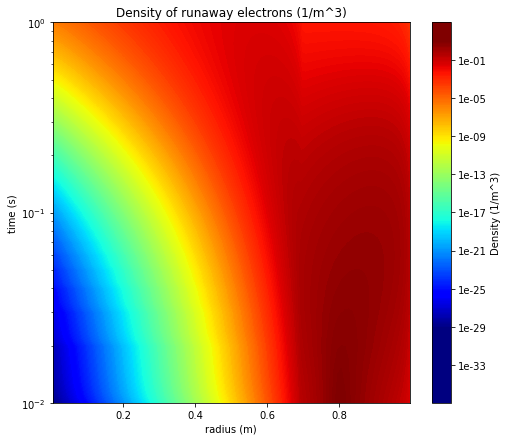

In [20]:
## Dirac delta in the initial condition
## Neumann boundary condition, and Dirichlet boundary condition applicable
## Space (and time) dependent diffusion and convection coefficients applicable
## For re-initialization copy-paste the code below TEMPLATE

############################# TEMPLATE #################################

## code for setting up the translation of the mesh
## the translation is currently NOT WORKING properly
########
# R_from = 0.7  ## inner radius in meters
# R_to = 1.  ## outer radius in meters
# dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
########

R = 1.  ## radius
nr = 100  ## number of mesh cells
dr = R / nr  ## distance between the centers of the mesh cells
duration = 1.  ## length of examined time evolution in seconds
nt = 100  ## number of timesteps
dt = duration / nt  ## length of one timestep

## 3D array for storing the density with the correspondant radius values
## the density values corresponding to the n-th timestep will be in the n-th line 
solution = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    solution[:,j,0] = j * dr + dr / 2

mesh = fp.Grid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
## translation of mesh - NOT WORKING
# mesh = mesh + ((0.7,), )  ## translating the mesh to r=0.7
n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep

diracLoc = 0.8  ## location of the middle of the Dirac delta
diracCoeff = 1.  ## Dirac delta coefficient ("height")
diracPercentage = 2.5  ## width of Dirac delta (full width from 0 to 0) in percentage of full examined radius
diracWidth = int((nr / 100) * diracPercentage)
## it's possible to give more than one Dirac delta initial conditions
# diracLoc2 = 0.9 
# diracCoeff = 2.
# ...

## static diffusion and convection coefficients
# diffCoeff = 1.
# convCoeff = (1.,)  ## must be a vector

## space dependent diffusion coefficient
diffCoeff = fp.CellVariable(mesh=mesh, value= 0.01 * numerix.cos(mesh.x) ** 2 + 0.1)
## space dependent convection coefficient - must be a vector
cC = (numerix.sin(mesh.x)) * 2
convCoeff = fp.CellVariable(mesh=mesh, value=[cC])

## boundary conditions
gradLeft = (0.,)  ## density gradient (at the "left side of the radius")
valueRight = 0.  ## density value (at the "right end of the radius")
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
## until translation of the mesh doesn't work:
convCoeff.setValue(0, where=mesh.x<0.7)  ## convection coefficient inside the closed magnetic flux surface
diffCoeff.setValue(0.01, where=mesh.x<0.7)  ## diffusion coefficient inside the closed magnetic flux surface

## applying initial conditions
n.setValue(delta_func(mesh.x - diracLoc, diracWidth * dr, diracCoeff))
## for more Dirac deltas or for setting initial value: add code here^

## The equation with intuitive naming - corresponding coefficients as arguments
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Solving the PDE in every timestep and
## loading space dependent data into the solution array
for i in range(nt):
    eq.solve(var=n, dt=dt)
    solution[i,0:nr,1]=copy.deepcopy(n.value)

## plotting - plot_solution(solution_array,ticks=8,levels=300,bottom_log=30,figsize=(8,7))
plot_solution(solution,ticks=9)

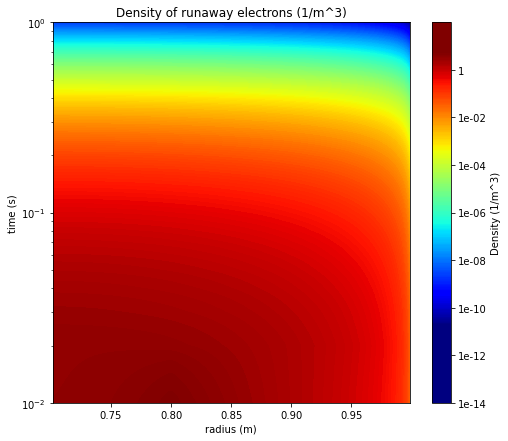

In [21]:
## TRANSLATION OF MESH WORKING

R_from = 0.7  ## inner radius in meters
R_to = 1.  ## outer radius in meters
nr = 100  ## number of mesh cells
dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
duration = 1.  ## length of examined time evolution in seconds
nt = 100  ## number of timesteps
dt = duration / nt  ## length of one timestep

## 3D array for storing the density with the correspondant radius values
## the density values corresponding to the n-th timestep will be in the n-th line 
solution = np.zeros((nt,nr,2))
## loading the radial coordinates into the array
for j in range(nr):
    solution[:,j,0] = (j * dr) + (dr / 2) + R_from

mesh = fp.Grid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
mesh = mesh + (0.7,)  ## translating the mesh to r=0.7
n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep

diracLoc = 0.8  ## location of the middle of the Dirac delta
diracCoeff = 1.  ## Dirac delta coefficient ("height")
diracPercentage = 2.5  ## width of Dirac delta (full width from 0 to 0) in percentage of full examined radius
diracWidth = int((nr / 100) * diracPercentage)

## diffusion coefficient
diffCoeff = fp.CellVariable(mesh=mesh, value=1.)
## convection coefficient - must be a vector
# cC = (numerix.sin(mesh.x)) * 2
convCoeff = fp.CellVariable(mesh=mesh, value=(1.,))

## boundary conditions
gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
valueRight = 0.  ## density value (at the "right end of the radius")
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition

## applying initial conditions
n.setValue(delta_func(mesh.x - diracLoc, diracWidth * dr, diracCoeff))
## the PDE
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Solving the PDE and storing the data
for i in range(nt):
    eq.solve(var=n, dt=dt)
    solution[i,0:nr,1]=copy.deepcopy(n.value)

## plotting - plot_solution(solution_array,ticks=8,levels=300,bottom_log=30,figsize=(8,7))
## if getting contour levels must be increasing error, adjust bottom_log
plot_solution(solution, bottom_log=10)